In [1]:
#Import stuff and set up slides
import utils_anna
import render_anna
from IPython.display import SVG # SVG capabilities for showing layouts
from gurobipy import *

%matplotlib inline

from traitlets.config.manager import BaseJSONConfigManager
path = "C:/Users/feita1/.jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update('livereveal', {
              'theme': 'sansserif',
              'transition': 'fade',
              'start_slideshow_at': 'selected',
                'scroll': True,
                'slideNumber': False,
});


<img src="imgs/logo.png" width="100%">


# Day 2: Exact Methods and Integer Programming

#### <a href="http://www.annafeit.de">Anna Feit</a> / Aalto University

This notbeook provides an introduction to integer programming for formulating and solving user interface design problems. <a href="Computational-Interaction-Summer-School-2017-Optimization-Oulasvirta.ipynb">Another notbeook</a> by Antti Oulasvirta gives a general introduction to UI optimization and focuses on heuristic methods. 

### Content
<ol>
<li>What is Integer Programming and why should we use it
<li>Formulating problems
<li>The assignment problem
<li> Variations of the assignment problem
<li>Keyboard optimization
<li>Branch and bound
</ol>

#### Primary sources
1. Rao, S.R. Engineering Optimization: Theory and Practice. John Wiley & Sons, 2009.
2. Wolsey, Laurence A. Integer Programming. Wiley, 1998.
3. Andreas Karrenbauer and Antti Oulasvirta. 2014. Improvements to keyboard optimization with integer programming. In Proc. of the 27th annual ACM symposium on User interface software and technology (UIST '14). ACM

# 1. What is Integer Programming and why should we use it
***

Integer Programming is an **exact method** for solving optimization problems. It has been applied in many disciplines to solve all kind of different problems, such as:
-  Deciding the best schedule for airline crews, lectures, or trains
-  Finding the best location for depots, supermarkets, or firestations
-  Planning the schedule to produce a product with different parts at different locations, including optimal transport
-  Minimize waste in a production process, e.g. cutting fabric to make clothes

Many different areas make use of integer programming, from telecommunications to engineering, computer science, biology, economics, etc. 


The goal of this lecture is to give you an introduction to Integer Programing, to convince you that it is a powerful tool also to solve problem in HCI, and to show you how to formulate and solve those problems. 

## Exact versus heuristic methods
| Criterion |Exact methods | Heuristic methods |
|-----------------------------------|
|**Solution**| + Guarantees to find the global optimum in finite time (but might be exponential) <br> + Gives explicit optimality bounds for incumbent solutions <br> - may not give any reasonable solution within a given time  | + Can get some good solution quickly <br> - No notion of solution quality (bound) <br> - No guarantee to find the global optimum in finite time and might get stuck in local optimum |
|**Performance and implementation** | + Fast solvers available (e.g. Gurobi, CPLEX) <br> + Easy implementation once the model is decided <br> - Mathematical formulation of the problem may be hard and requires some practice <br> - Covering the full design space might be slow and unnecessary in certain cases | • Some implementations of common heuristics available (e.g. SciPy, Optimization Toolbox Matlab) <br> - Requires careful implementation of design space and tweaking of heuristics case by case <br> + More flexibility when only some good solution is required |
|**Flexibility in objectives**|- Objective function may be hard or impossible to formulate in an efficient, closed mathematical form <br> - Limitations when trading-off different objectives | + Objective function can be any data source or computable function (e.g. simulation model, crowdsourcing data, etc. ) <br> + Easier to compute pareto front for trading-off multiple objectives<br> - Flexibility comes at the cost of performance|
| **Representation of feasible set** | + Rigorous constraints, clearly formulated | • Implementation of constraints can get confusing as problems become more complex |

## Exact methods give guarantees

#### Guarantees to find the global optimum
The simplest exact method is **explicit enumeration**, where the objective value of each element of the solution space is evaluated, and the current best solution -- the so-called **incumbent** -- is updated (basically brute-force). 

In **implicit enumeration** relaxations are used to make the problem tractable. Relaxations are *simplifications* to a problem, obtained, for example by removing or simplifying constraints that make the problem easier to solve. Solving these simplified problems gives us a bound on the objective score of the original problem. This is used, for example, by the branch-and-bound method (discussed below) that uses these bounds to safely discard parts of the solution space.

#### Guarantees on the solution quality
The bounds obtained by the relaxation deliver us **guarantees for the quality** of the incumbent: no solution can be better than the bound and, thus if the objective value of the incumbent is only 1% away from the bound, we know that it can also be at most 1% away from the global optimum. 

## Powerful solvers available

such as <a href="http://www.gurobi.com/">Gurobi</a> and <a href="https://www-01.ibm.com/software/commerce/optimization/cplex-optimizer/"> CPLEX (IBM)</a>.

Here we will use Gurobi.
<ul>
<li> Free for academic use
<li> Solves (Mixed Integer) Linear Programs, Quadratic Programs, and Quadratically Constrained Programs
<li> Interfaces for **Python**, C, C++, Java, .NET, MATLAB, R, and Excel
</ul>

## What is Integer Programing? 

### Recap:  Design task and space
$$\mbox{Find } \mathbf{x} =
	\begin{pmatrix}
	x_1 \\
	x_2 \\
	\vdots \\
	x_n
	\end{pmatrix} \in \mathbf{X}
\mbox{ which maximizes } f(\mathbf{x})$$
where 
* $\mathbf{x}$ is an *n*-dimensional **design vector**,  each dimension describing a **design variable**, and
* $\mathbf{X}$ is **the set of designs** (all to-be-considered design vectors).

#### In Integer Programming we require each variable to be of type integer (or boolean) but not real. 

# 2. Formulating Problems
***

The formulation of the design problem is essentiel for exact methods, such as Integer Programming. In operations research, the problem formulation is called **model**. Formulating the model consists of three steps: 

<ol>
<li> Define the decision variables and design space
<li> Define constraints that characterize the set of feasible solutions
<li> Define the objective function
</ol>

Attention: the <i>optimization</i> model in this context should not be confused with behavioral models such as Fitts' Law or other. 

### 1. Decision variables

The design variables $\mathbf{x} = (x_1, \ldots x_n)$ are also called **decision** variables.
We can consider the design process as a set of decisions, such as 
<ul>
<li> Is the button green, blue, or red?
<li> Does clicking the button provide auditory feedback or not? 
<li> Should it be positioned on top of the form or below it?
</ul>

All possible combinations of answers constitute the space of possible designs. 

### 2. Constraints

Restrictions on the design variables that must be satisfied to produce an acceptable design. Constraints could be
<ul>
<li> limitations inherent to the design problem (e.g. no entry in a menu should appear twice)
<li> functional or semantic (e.g. if an application offers the functionality "paste" it must also offer "copy")
<li> user or customer pereferences (e.g. The companies logog must be place on the top right of the webpage)
<li> ...
</ul>

### 3. Objective function
Each decision is associated with a **cost**. The objective function (or evaluation function) consists of criteria that quantify the cost of a decision or design. The goal is then to find the design vector that minimizes the objective function. (Note: minimization = maximization)

Caveat: The objective function must be in **closed mathematical form** and only contain linear or quadratic terms 



# 3. The assignment problem
***
<img style="float:right;" src="imgs/assignmenr_problem.PNG"  width=50%>
Classical problem in combinatorial optimization. Similar to others, these are often inspired by real-life scenarios.

**Given:** a number N of agents and tasks<br>
a cost $c_{ij}$ assigning agent i to task j 

||Task 1|Task 2|Task 3|Task 4|
|----------------------------|
|**Agent 1**|$c_{11}$|$c_{12}$|$c_{13}$|$c_{14}$|
|**Agent 2**|$c_{21}$|$c_{22}$|$c_{23}$|$c_{24}$|
|**Agent 3**|$c_{31}$|$c_{32}$|$c_{33}$|$c_{34}$|
|**Agent 4**|$c_{41}$|$c_{42}$|$c_{43}$|$c_{44}$|
 
**Goal:** assign each task to exactly one agent so that the cost is minimized.


Warning: we will use a different metaphor here and then come back to HCI problems

### 1. Decision variables
Binary decision variables: 
<img src="imgs/assignment_graph.PNG" style="float:right" width=30%>
$\mathbf{x} = (x_{11},x_{12}, ... x_{NN}), \quad x_{ij} \in \{0,1\}$ <br>
$x_{ij} = 1$ if agent i is assigned to task j, $0$ otherwise

Note: such decision variables can be represented as edges in a graph. Here we have the special case of a bipartite graph. This important property allows us to apply many concepts and algorithms from graph theory to solve our problems. 



### 2. Constraints
<img src="imgs/assignment_graph2.PNG" style="float:right" width=30%>
Each task j must be assigned to exactly 1 agent:
$$\sum_{i=1}^N x_{ij} = 1 \quad \forall j = 1 \cdots N$$

Each agent i must be assigned to exactly 1 task:
$$\sum_{j=1}^N x_{ij} = 1 \quad \forall i = 1 \cdots N$$

### 3. Objective function
<img src="imgs/assignment_graph3.PNG" style="float:right" width=30%>
Minimize the costs for assigning agents to tasks

Example: 4 agents and 4 tasks<br>
Cost for agent 1: <br>
$$c_{11} x_{11} + c_{12} x_{12} + c_{13} x_{13} + c_{14} x_{14}  = \sum_{j=1}^4 c_{1j} x_{1j} $$

Cost for the assignment: <br>
$$\sum_{i=1}^N\sum_{j=1}^N c_{ij} x_{ij}  = c_{11} x_{11} + c_{24} x_{24} + c_{33} x_{33} + c_{42} x_{42}$$

Objective function: 
$$min \sum_{i=1}^N\sum_{j=1}^N c_{ij} x_{ij} $$

## The *linear* assignment problem: 
$$min \sum_{i=1}^N\sum_{j=1}^N c_{ij} x_{ij} $$
$$\text{subject to} \hspace{6cm} $$
$$\sum_{i=1}^N x_{ij} = 1\hspace{1cm} \forall j = 1 .. N$$
$$\sum_{j=1}^N x_{ij} = 1\hspace{1cm} \forall i = 1 .. N$$
$$x_{ij} \in {0, 1} \hspace{1.6cm} \forall i, j = 1 .. N$$

The objective function and constraints contain only linear terms. Problems that can be modeled like this can be efficiently solved in polynomial time. 

Note: The problem of assigning each agent to exactly one task, if the number of agents and tasks are the same, is the same as finding a <a href="https://en.wikipedia.org/wiki/Matching_(graph_theory)#In_unweighted_bipartite_graphs">matching in a bipartite graph </a>. Formulating the problem like this allows us to make use of many standard algorithms that easily solve this problem in polynomial time. 

<div class="alert alert-block alert-success">
<h3> Exercise 1: Assignment problems in HCI </h3>
Can you think of examples from HCI that involve an assignment problem? 

## Linear menu design
Consider again the example of designing a linear menu:

| Aspect | Content|
|----------|------|
| Design task | Given *n* menu items, decide their order to minimize expected selection time |
| Design space | All possible orderings of the items (*n!* in total)  |
| Objective function | Minimize expected selection time |
| Task instance | Specification of elements and their relative importance |
| Solver | **Gurobi solver for integer programming** |

<img src="imgs/menus.png" width="90%">


## Problem formulation: linear assignment problem

The cost $c_{ij}$ for assigning an item i to a position j is defined by the expected time to select the item: $c_{ij} = p_i \cdot d_j \cdot r$. 
<br> Thus the problem can be formulated as:
$$min \sum_{i=1}^N\sum_{j=1}^N p_i \cdot d_j \cdot r \cdot x_{ij} $$
$$\text{subject to} \hspace{6cm} $$
$$\sum_{i=1}^N x_{ij} = 1\hspace{1cm} \forall j = 1 .. N$$
$$\sum_{j=1}^N x_{ij} = 1\hspace{1cm} \forall i = 1 .. N$$
$$x_{ij} \in {0, 1} \hspace{1.6cm} \forall i, j = 1 .. N$$

## Gurobi implementation

The following code example shows how to implement and solve this model with the mathematical solver Gurobi: 
<ol>
<li> Create the (empty) model
<li> Define decision variables
<li> Define constraints
<li> Define objective function
<li> Optimize model
<li> Extract solution
</ol>

In [3]:
def solve(elements, positions, frequency, distance):
    # ==== 1. Create the (empty) model ====
    model = Model("linear_menu")

    # ==== 2. Add decision variables ======
    x = {}
    # Create one binary variable for each element-position pair. 
    # We give it a meaningful name so we later understand what it means
    # if it is set to 1
    for e in elements:
        for p in positions:
            x[(e,p)] = model.addVar(vtype=GRB.BINARY, name="%s_%i"%(e,p))            
    # Integrate new variables
    model.update()
    
    # ====3. Add Constraints ======
    # Add constraints
    # Each position is only assigned to one element
    for p in positions: 
        model.addConstr(quicksum(x[(e,p)]
                   for e in elements) == 1, "uniqueness_constraint_%i"%p)    
    # Each element is only assigned to one position
    for e in elements: 
        model.addConstr(quicksum(x[(e,p)]
                   for p in positions) == 1, "uniqueness_constraint_%s"%e)
    model.update()
    
    # ==== 4. Specify Objective function ======
    reading_cost = 0.4 # assumed that scanning a single item takes 400 ms
    
    # Sum up the costs for mapping any element e to any position p 
    cost = quicksum(frequency[e] * distance[p] * reading_cost * x[(e,p)]
                                for e in elements
                                   for p in positions)
    model.setObjective(cost,GRB.MINIMIZE)

    
    # ==== 5. Optimize model ======    
    model.optimize()
    
    # ====6. Extract solution ======   
    layout = [None]*len(elements)
    #create the layout (ordered list of elements) from the variables 
    #that are set to 1
    for v in model.getVars():
        if v.x == 1:
            element = v.varName.split("_")[0]        
            position = int(v.varName.split("_")[1])
            layout[position] = element                 
    
    return layout, model.getObjective().getValue()
    
    

We also need to define the particular task instance we want to solve including definition of elements, their 'importance' (frequency), and the available positions

In [4]:
#define elements and positions
elements = ['Open', 'About','Quit','Help','Close',
            'Save','Edit','Insert','Delete']
positions = list(range(len(elements)))

In [5]:
#define cost factors
frequency = {'Quit':0.3,'About':0.2,'Open':0.1,'Save':0.1,'Close':0.05,
             'Help':0.02,'Edit':0.08,'Insert':0.1,'Delete':0.05}
distance = map(lambda p:utils_anna.distance(1,0,p), positions)

Optimize a model with 18 rows, 81 columns and 162 nonzeros
Variable types: 0 continuous, 81 integer (81 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.424
Presolve time: 0.00s
Presolved: 18 rows, 81 columns, 162 nonzeros
Variable types: 0 continuous, 81 integer (81 binary)

Root relaxation: objective 9.240000e-01, 38 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.9240000    0.92400  0.00%     -    0s

Explored 0 nodes (38 simplex iterations) in 0.04 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 0.924 1.424 
Pool objective bound 0.924

Optimal solution found (tolerance 1.00e-04)
Best objective 9.240000000000e-01, best bound 9.240000000000e

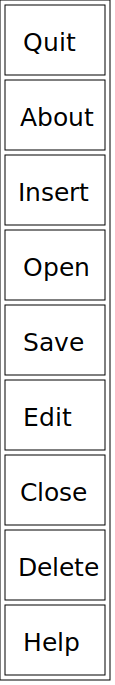

In [6]:
#solve the problem
layout, objective = solve(elements, positions, frequency, distance)
 
#Print the solution
print "Objective value (expected selection time):", objective
#plot the layout
SVGlayout = render_anna.SVGlayout(layout,1)
SVG(SVGlayout.inSVG)

Gurobi Output explained: 

`Optimize a model with 18 rows, 81 columns and 162 nonzeros 
Variable types: 0 continuous, 81 integer (81 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]`
 
 
Statistics about the to-be-solved problem: the number of constraints (rows), the decisions variables (columns) and properties about their values.

`Found heuristic solution: objective 1.424
Presolve time: 0.01s
Presolved: 18 rows, 81 columns, 162 nonzeros
Variable types: 0 continuous, 81 integer (81 binary)`
Objective value of a solution find via heuristics, the time to simplify (presolve) the problem and updated statistic about the problem

`Root relaxation: objective 9.240000e-01, 38 iterations, 0.00 seconds`
The objective value of the relaxed version of the original problem. 

`   Nodes    |    Current Node    |     Objective Bounds      |    Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.9240000    0.92400  0.00%     -    0s`
The number of explored and unexplored nodes in the enumerative tree, information about the current node, 
the objective value of the current incumbent solution, the best bound found so far, and the corresponding gap, The number of simplex iterations used per node to solve the realxation, and the time used so far for solving the problem


`Explored 0 nodes (38 simplex iterations) in 0.05 seconds
Thread count was 4 (of 4 available processors)`
Information about the performance. 

`Solution count 2: 0.924 1.424 
Pool objective bound 0.924`
The objective values of the last X incumbent solutions and the best bound found for them. 

`Optimal solution found (tolerance 1.00e-04)
Best objective 9.240000000000e-01, best bound 9.240000000000e-01, gap 0.0000%`
If an optimal solution was found, the best objective value, best bound, and corresponding gap. 

### Model-data separation
Above, we have first implemented the model and then defined the concrete problem instance with elements, positions, and the corresponding cost factors.

A clean separation between the optimization model and the problem data (cost values, variables, etc.) is useful because: 
<ul>
<li> Makes it easy to switch between test data and a real system
<li> Allows to reuse optimization models for different instances
<li> Easily include data from different sources (database, files, generated, etc.)
<li> Good programing practice for more flexible and easier to understand code
</ul>

<div class="alert alert-block alert-success">
<h3> Exercise 2: Trading off different users</h3>
<p>Assume that you have two different user groups that use the menu in very different ways, e.g. novice versus expert users. </p>
<p>Given two sets of frequency distributions for the menu items, $p^{novice}$ and $p^{expert}$ your task is to reformulate the objective function so that it finds the best design for both user groups. </p>
</div>

# 4. Variations of the linear assignment problem
***

## The generalized assignment problem
Allows to model capacities for assigning several tasks to an agent: 

<img style="float:left" src="imgs/gen_assignment_problem.PNG" width=30%>
Assigning an agent i to a task j has a profit $p_{ij}$ but also work cost $c_{ij}$

An agent i can work on multiple tasks but has a work capacity $t_i$

Goal: Assign each task to exactly one agent such that the profit is maximized and no agent works more than his capacity allows. 


$$\color{red}{max}  \sum_{i=1}^N\sum_{j=1}^M \color{red}{p_{ij}} x_{ij} $$
$$\text{subject to} \hspace{6cm} $$
$$\sum_{i=1}^N x_{ij} = 1 \hspace{1cm} \forall j = 1 \ldots M$$
$$\color{red}{\sum_{j=1}^n c_{ij} x_{ij} \leq t_i \hspace{0.55cm} \forall i = 1 \ldots N}$$
$$x_{ij} \in {0, 1} \hspace{1.6cm} \forall i = 1 .. N, j = 1 \ldots M$$

## The quadratic assignment problem
Allows to model relationships between the elements of the two sets. 

<img src="imgs/quadr_ass_problem.PNG" style="float:right", width=40%>

Scenario: we want to assign a number of factories to different locations in an optimal manner. 

The difference to the linear assignment problem is that here the cost for assigning a factory to a location does also depend on its flow of good to other factories and the distance of that location to the locations of the other factories. If many goods are transported from one factory to another, they should be located close to each other. 


### Problem formulation

<ol>
<li> Decision varibales:
$x_{ik} = 1$ if factory is i assigned to location k, $0$ otherwise. 
<li> Constraints: <br>
At each location k there must be exactly one factory i :
$$\sum_{i=1}^N x_{ik} = 1 \quad \forall k = 1 \cdots N$$

Each factory i must be assigned to exactly one location k:
$$\sum_{k=1}^N x_{ik} = 1 \quad \forall i = 1 \cdots N$$

</ol>

<img src="imgs/quadr_ass_problem2.PNG" style="float:right", width=30%>

3 . Objective function: <br>
In the example on the right, the cost for assigning factories 1 and 2 to locations 3 and 4 is: 
$$f_{12} \cdot d_{34} \cdot x_{13} \cdot x_{24}$$
To solve the optimization problem, we want to minimize this cost for all possible pairs of factories and locations. This is computed by: 
$$\color{red}{min \sum_{i=1}^n \sum_{j=1}^n \sum_{k=1}^n \sum_{l=1}^n f_{ij} \cdot d_{kl} \cdot x_{ik} \cdot x_{jl}} $$

Thus, we can take into account relationships between elements of each set by simply changing the objective formulation. Overall, we get the following problem formulation: 

$$\color{red}{min \sum_{i=1}^n \sum_{j=1}^n \sum_{k=1}^n \sum_{l=1}^n f_{ij} \cdot d_{kl} \cdot x_{ik} \cdot x_{jl}}$$
$$\text{subject to} \hspace{6cm} $$
$$\sum_{i=1}^N x_{ij} = 1\hspace{1cm} \forall j = 1 .. N$$
$$\sum_{j=1}^N x_{ij} = 1\hspace{1cm} \forall i = 1 .. N$$
$$x_{ij} \in {0, 1} \hspace{1.6cm} \forall i, j = 1 .. N$$

## The quadratic assignment problem in HCI

The quadratic assignment problem is useful if we want to model relationships between UI elements, for example with respect to:

<img style="float: right; margin-left:20pt;"src="imgs/amazon.PNG" width="50%">

<ul>
<li> **User's interaction**, e.g. the search button is often clicked after entering text in the search field
<li> **Functional, visual, or other similarity**, e.g. links to different supbages are placed in a row next to each other
<li> **Aesthetics or pleasure**, e.g. pictures are placed next to each other and vertically and horizontally aligned
<li> etc. 
</ul>



# 5. Keyboard optimization
***
## The letter assignment problem 
<img style="float: right; "src="imgs/letter_assignment.png" width="40%">
A prominent example of the quadratic assignmenr problem in HCI is the letter assignment problem: 

Scenario: How should we place N characters on the keys of a keyboard so that we can type fastest?

For 26 letters and 26 keys there are $26! > 10^{25} $ different mappings, way to many to manually search and test for the best one. 



<div class="alert alert-block alert-success">
<h3> Exercise 3a: Modeling the letter assignment problem</h3>

How can you model the problem of assigning characters to keyslots on a keyboard mathematically?
<ol>
<li> Define the decision variables
<li> Add the necessary constraints
<li> Formulate the objective function. 
</ol>

<div class="alert alert-block alert-success">
<h3> Exercise 3b: Implementing the letter assignment problem in Gurobi</h3>
Implement the model in Gurobi and optimize a keyboard layout for the given letters.
</div>

In [ ]:
#Implement the model for the letter assignment problem below

def solve(characters, keyslots, bigram_frequency, movement_time):
    # ==== 1. Create the (empty) model ====
    model = Model("keyboard")
    
    # ==== 2. Add decision variables ======
    x = {}
    # Create one binary variable for each letter-key pair.     
    for i in characters:        
        for k in keyslots:                
            x[(i,k)] = model.addVar(vtype=GRB.BINARY, name="%s_%i"%(i,k))            
    # Integrate new variables
    model.update()    
    
    # ====3. Add Constraints ======
    # Each letter is only assigned to one keyslot
    for i in characters: 
        model.addConstr(quicksum(x[(i,k)]
                           for k in keyslots) == 1, "uniqueness_constraint_%s"%i)    
    # Each element is only assigned to one position
    for k in keyslots: 
        model.addConstr(quicksum(x[(i,k)]
                           for i in characters) <= 1, "uniqueness_constraint_%i"%k)
    
    model.update()
    
    # ==== 4. Specify Objective function ======        
    # TODO: implement the objective function here    
    
    
    
    
    # ==== 5. Optimize model ======    
    model.optimize()
    
    # ====6. Extract solution ======   
    mapping = {}
    
    for v in model.getVars():
        if v.x == 1:
            character = v.varName.split("_")[0]
            slot = int(v.varName.split("_")[1])
            mapping[character] = slot
            
    return mapping, model.getObjective().getValue()

In [ ]:
# DO NOT CHANGE ANYTHING HERE. This is the input data to the model. 
# If the solve function is implemented correctly, running this code will optimize a keyboard layout for 9 characters. 
# This should only take about 5 seconds

#define characters and keyslots
characters = ['a', 'c', 's', 'r', 'e', 'q', 't', 'h', 'i']
keyslots = list(range(len(characters))) 
columns = 3

#obtain cost factors: movement time and bigram frequencies
movement_time = {(s1,s2): utils_anna.fittslawcost(s1,s2, utils_anna.distance(columns,s1,s2)) for s1 in keyslots for s2 in keyslots}

#letter pair frequency        
bigram_frequency = utils_anna.get_bigram_frequency(characters)

#solve the problem
mapping, objective = solve(characters, keyslots, bigram_frequency, movement_time)

print "The average WPM of the winning keyboard is %.2f"%utils_anna.wpm(objective)
render_anna.plot_keyboard(mapping, columns)

<div class="alert alert-block alert-success">
<h3> Bonus task:</h3>
<p>We really want to name our keyboard the "HCI" keyboard.</p>

<p>Therefore, your task is to change the mathematical model and its implementation so that the letters H - C - I are placed next to each other on any of the rows of the computer, as in the example keyboard below. Do not change the input data.</p>
<p>
How much worse is this keyboard in comparison to the unconstrained problem?</p>                                                 
</div>                                                         

# 6. Branch and Bound

## How is an Integer Program solved?
Mathematical solvers guarantee to find the global optimum. They can only do this by explicitly or implicitly evaluating every solution. In the following we are going to look at one method to do this in more detail: **branch and bound**


## Linear versus Integer Program
In general, solving an integer program is hard, in the sense that it is computationally intensive. But, if we remove the integer  constraint and allow the decison variables to take any real value, the problem becomes a *linear program*, which is much faster to solve for example with the <a href="https://en.wikipedia.org/wiki/Simplex_algorithm">simplex method</a>. This linear problem is called **relaxation**.

Problem: there is no easy way to obtain the optimal integer solution from the optimal solution to the linear program. 

The solution from the linear program only serves as a **dual bound**. In case of a maximization problem, this is also called **upper bound**: no integer solution can have a higher objective value than the solution to the linear program. 

Any feasible solution is a **primal bound** or **lower bound** for maximization problems: the objective value of the optimal integer solution will be at least as good as the lower bound.

<img src="imgs/lin_int.PNG" width=40% style="float:right">
Example:
$$max \hspace{0.3cm} x_1 + 0.64 x_2$$

$$\text{subject to} \hspace{4cm}$$

$$\color{blue}{50 x_1 + 31 x_2 \leq 250}$$

$$\color{red}{3 x_1 - 2 x_2 \geq -4}$$

$$x_1, x_2 \in \mathbf{Z}^+ $$

Optimal value: $ 1.64 \leq z \leq 5.1$


## Branch and bound
To solve the integer program, we iteratively compute tighter and tighter bounds by finding good approximate solutions, solving easier (linear) problems and refining the problem to make it easier to solve. 

Branch and bound is one technique to do this. Basic idea for the *binary* integer program (e.g. keyboard optimization): 
<ul>
<li> Use an enumerative tree to go through all possible solutions
<li> At each node, divide the problem into easier subproblems by settting one of the decision variables either to 1 or 0 (*branch*)
<li> solve the subproblem to obtain a *primal bound* or solve a relaxation of the subproblem to obtain a *dual bound*
<li> use the bounds to exclude subsets of the solution space that cannot lead to an optimal solution (*prune*). 
</ul>



There are 3 ways of pruning: 
<ul>
<li> Pruning by infeasibility: the subproblem violates one or more constraints
<li> Pruning by optimality: the subproblem has been solved to optimality but the dual bound of another subproblem is better
<li> Pruning by bound: the dual bound is worse than the primal bound of another subproblem
</ul>
<img src="imgs/tree.PNG" width=100%>